In [31]:
'''
extraction of error logs (only failures)
output: CSV/pkl file
usueful to perform offline analysis 
`cid` can be tuned (eg 30-100K)
'''
from pandas import DataFrame
import MySQLdb
import bz2

cids = []
errors = []
       
try:
    socket = MySQLdb.connect("148.60.11.195", "script", "irmadb2019", "IrmaDB_prod")
    cursor = socket.cursor()
#   cursor.execute("SELECT cid, errlog_file FROM Compilations WHERE core_size = -1 and cid > 100000")
#   cursor.execute("SELECT cid, errlog_file FROM Compilations WHERE core_size = -1 and cid >= 30000 and cid <= 100000")
    cursor.execute("SELECT cid, errlog_file FROM Compilations WHERE cid >= 20000 AND cid <= 25000") # all error logs even when there is no failure
   
    for row in cursor.fetchall():
        cid = row[0]   
        if (row[1] is None):
            print ("Unable to retrieve cid=", str(cid))
        try:
            log_error = bz2.decompress(row[1]).decode('utf-8')
           #log_error = log_error.replace('\r', '').replace('\n', '')
        except Exception as e:
            print(str(e),"\n" + "Unable to decompress... ", file=sys.stderr)
            exit(-1)
        
        cids.append (cid)
        errors.append (log_error)
    
    Errlogs = {'cid': cids, 'error_message': errors}
    df = DataFrame(Errlogs, columns= ['cid', 'error_message'])
    # export_csv = df.to_csv ('errlogs-25000-30000.csv', index = None, header=True) 
    
except Exception as e:
    print(str(e),"\n" + "Unable to connect to database c = " + str(cid), file=sys.stderr)
    exit(-1)    
finally:
    cursor.close()
    socket.close()

In [32]:
df['cid'][:10]

0    20000
1    20001
2    20002
3    20003
4    20004
5    20005
6    20006
7    20007
8    20008
9    20009
Name: cid, dtype: int64

In [33]:
#df.query("cid == '57116'")['error_message']

In [34]:
#len(df)

In [35]:
df.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Columns: 2 entries, cid to error_message
dtypes: int64(1), object(1)
memory usage: 78.2+ KB


In [65]:
cids_witherror = []
for i, d in df.iterrows():
    err = d['error_message']
#    print (err)
#    break   
    error = False
    for e in err.splitlines():
        if "Cyclomatic" not in e:
            # ("fail" in e) or 
            if (("error:" in e) or ("Error:" in e) or ("Error" in e) or ("not found" in e) or ("undefined" in e) or ("ERROR:" in e)):
                error = True
                print (e)
    if error:
        cid = d['cid']
        cids_witherror.append(cid)
        print ("ERROR in configuration id", cid)
        print()
        print()


    

make[4]: bison: Command not found
make[4]: *** [/TuxML/linux-4.13.3/drivers/scsi/aic7xxx/aicasm//aicasm_gram.h] Error 127
make[3]: *** [drivers/scsi/aic7xxx/aicasm/aicasm] Error 2
make[2]: *** [drivers/scsi/aic7xxx] Error 2
make[1]: *** [drivers/scsi] Error 2
make: *** [drivers] Error 2
ERROR in configuration id 20125


make[4]: bison: Command not found
make[4]: *** [/TuxML/linux-4.13.3/drivers/scsi/aic7xxx/aicasm//aicasm_gram.h] Error 127
make[3]: *** [drivers/scsi/aic7xxx/aicasm/aicasm] Error 2
make[2]: *** [drivers/scsi/aic7xxx] Error 2
make[1]: *** [drivers/scsi] Error 2
make: *** [drivers] Error 2
ERROR in configuration id 20235


ERROR: "gen_pool_virt_to_phys" [drivers/staging/vboxvideo/vboxvideo.ko] undefined!
ERROR: "gen_pool_add_virt" [drivers/staging/vboxvideo/vboxvideo.ko] undefined!
ERROR: "gen_pool_destroy" [drivers/staging/vboxvideo/vboxvideo.ko] undefined!
ERROR: "gen_pool_dma_alloc" [drivers/staging/vboxvideo/vboxvideo.ko] undefined!
ERROR: "gen_pool_create" [drivers/st

In [42]:
import pandas as pd

df2030 = pd.read_csv('config_bdd20000-30000.csv')


/usr/local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (1150,6015,6026,7676,7726) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [60]:
df2030.query("cid == 24965")[['cid', 'DRM_VBOXVIDEO', 'GENERIC_ALLOCATOR']]

,cid,DRM_VBOXVIDEO,GENERIC_ALLOCATOR
4927,24965,m,n


In [69]:
from enum import Enum, auto
class ErrorLog(Enum):
    BLACKLIGHT = auto(),
    BLACKLIGHT2 = auto(),
    CONFIG_NLS_DEFAULT = auto(),
    CRC32_CLUSTER = auto(),
    V4L2 = auto(), 
    OVERFLOW2 = auto(), 
    ULPI = auto(), 
    PCM = auto(),
    TTM = auto(), 
    AS68K = auto(), 
    GEN = auto(), 
    AICDB = auto(), 
    AIC7XXX = auto(),
    DRM_BRIDGE_CLUSTER = auto(),
    PINCTRL_CLUSTER = auto(), 
    BTBCM = auto(),
    BPFFANCY = auto(), 
    DEVM = auto(), 
    DEVM2 = auto(), 
    I2C_CLUSTER = auto(), 
    VBOX_CLUSTER = auto(), 
    PCM_COBALT = auto()
    


    

patterns = { ErrorLog.BLACKLIGHT : "undefined reference to `backlight_device",
            ErrorLog.BLACKLIGHT2: 'error: ‘intel_backlight_device_register’', # 'intel_backlight_device_register', # cid 87044 does not match BACKLIGHT 
            ErrorLog.CONFIG_NLS_DEFAULT : "CONFIG_NLS_DEFAULT",
            ErrorLog.CRC32_CLUSTER : 'undefined reference to `crc32', 
            ErrorLog.V4L2 : 'undefined reference to `v4l2',
            ErrorLog.OVERFLOW2 : '__read_overflow2',
            ErrorLog.ULPI : 'undefined reference to `ulpi', # 100-126K dataset
            ErrorLog.PCM : 'undefined reference to `atmel_pcm_dma_platform', # 100-126K dataset
            ErrorLog.TTM : 'undefined reference to `ttm', 
            ErrorLog.AS68K: 'as68k: not found',
            ErrorLog.GEN : 'undefined reference to `gen_pool', 
            ErrorLog.VBOX_CLUSTER: '[drivers/staging/vboxvideo/vboxvideo.ko] undefined!',
            ErrorLog.AIC7XXX: '[drivers/scsi/aic7xxx/aicasm/aicasm] Error 2', #'drivers/scsi/aic7xxx',
            ErrorLog.AICDB : 'aicdb.h: No such file or directory', 
            ErrorLog.DRM_BRIDGE_CLUSTER : 'undefined reference to `drm_panel_bridge_add', 
            ErrorLog.PINCTRL_CLUSTER : '[drivers/pinctrl/pinctrl-mcp23s08.o] Error', #'pinctrl-mcp23s08', # loosely pattern (too general?)
            ErrorLog.BTBCM : 'undefined reference to `btbcm_set_bdaddr', 
            ErrorLog.PCM_COBALT : '[drivers/media/pci/cobalt/cobalt.ko] undefined', # snd_pcm # cid: 23262 
            ErrorLog.PCM_SND : 'snd_pcm', # snd_pcm # cid: 23262 
            ErrorLog.BPFFANCY : 'bpf-fancy', # loosely pattern (too general?)
            ErrorLog.DEVM : 'undefined reference to `__devm_regmap',
            ErrorLog.I2C_CLUSTER: 'error: implicit declaration of function ‘i2c_get_adapter’', #'i2c_get_adapter',
            ErrorLog.DEVM2 : 'undefined reference to `devm_of_led'
           }

pattern_name = [name for name, member in ErrorLog.__members__.items()]
# TODO: instead of having True/False values for each pattern column name, 
# let's have a single column with cluster(s) values
error_pattern = pd.DataFrame(columns=pattern_name, index=df['cid'])
error_pattern.fillna(False, inplace=True)

for i, errorlog in df.iterrows():
    error = errorlog['error_message']
    cid = errorlog['cid']
    for k, p in patterns.items():
        if (p in error):
            error_pattern.loc[cid][k.name] = True
            # TODO: error_pattern.loc[cid]['cluster_error'] = k.name
            #print (k.name, "found in configuration", cid)

BLACKLIGHT             0
BLACKLIGHT2            0
CONFIG_NLS_DEFAULT     0
CRC32_CLUSTER          0
V4L2                   0
OVERFLOW2              0
ULPI                   0
PCM                    0
TTM                    0
AS68K                  1
GEN                    0
AICDB                  0
AIC7XXX                4
DRM_BRIDGE_CLUSTER     0
PINCTRL_CLUSTER        0
BTBCM                  0
BPFFANCY               0
DEVM                   0
DEVM2                  0
I2C_CLUSTER            0
VBOX_CLUSTER          11
PCM_COBALT             1
dtype: int64

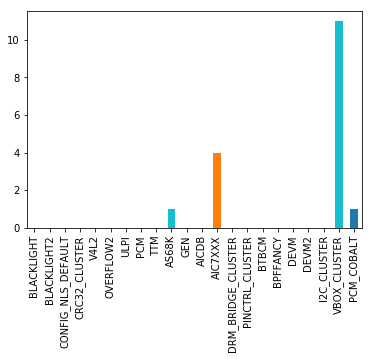

In [70]:
import matplotlib.pyplot as plt
%matplotlib inline  

def nb_patterns(row):
    return sum(row == True)                    
error_pattern['nb_patterns'] = error_pattern.apply(nb_patterns, axis=1)
pattern_frequencies = error_pattern[pattern_name].apply(nb_patterns, axis=0)
pattern_frequencies.plot(kind='bar')
pattern_frequencies

In [71]:
error_pattern.query("nb_patterns >= 1")

,BLACKLIGHT,BLACKLIGHT2,CONFIG_NLS_DEFAULT,CRC32_CLUSTER,V4L2,OVERFLOW2,ULPI,PCM,TTM,AS68K,...,DRM_BRIDGE_CLUSTER,PINCTRL_CLUSTER,BTBCM,BPFFANCY,DEVM,DEVM2,I2C_CLUSTER,VBOX_CLUSTER,PCM_COBALT,nb_patterns
cid,,,,,,,,,,,,,,,,,,,,,
20125,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,1
20235,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,1
20530,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,1
20893,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,1
21057,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,1
22365,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,1
23184,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,1
23262,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,1
23867,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,1


In [73]:
error_pattern.query("nb_patterns >= 1").shape, len(cids_witherror)

((17, 23), 17)